Генерация мультяшек с помощью вариационного автоэнкодера.

Давайте немного отвлечемся от тяжелых будней будущего нейронщика и вспомним, что в мире есть маленькие радости - а именно мультяшки. 

В этой работе: 
- скачайте датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip
- обучите VAE на данном датасете
- посмотрите качество воспроизведения мультяшек
- нагенерите мультяшек на свой вкус - оцените работу декодера

In [ ]:
# Подключим Numpy
import numpy as np

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Импортируем Keras
from tensorflow import keras

import tensorflow as tf

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose,MaxPooling2D

# Подключим модуль вычислений на Keras
import keras.backend as K

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

# загрузка файлов по HTML ссылке
import gdown
# импортируем модель Image для работы с изображениями
from PIL import Image 
# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

import re

In [ ]:
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip', None, quiet=True)

!unzip -q 'cartoonset10k.zip'  -d /content/cartoonset10k/    # распоковываем архив

In [ ]:
!ls /content/cartoonset10k

cs10000053986926948907.csv  cs10755719035366634500.csv
cs10000053986926948907.png  cs10755719035366634500.png
cs10000354665834323549.csv  cs10755748941826833799.csv
cs10000354665834323549.png  cs10755748941826833799.png
cs10000417372154603123.csv  cs10755957224249545546.csv
cs10000417372154603123.png  cs10755957224249545546.png
cs10000524080030775394.csv  cs1075609143194812341.csv
cs10000524080030775394.png  cs1075609143194812341.png
cs10000592242416795426.csv  cs10756219695542318383.csv
cs10000592242416795426.png  cs10756219695542318383.png
cs10000811708184140319.csv  cs10756288549453457405.csv
cs10000811708184140319.png  cs10756288549453457405.png
cs10000849938093558363.csv  cs10756327220067079832.csv
cs10000849938093558363.png  cs10756327220067079832.png
cs10000898984263089511.csv  cs10756991518761997041.csv
cs10000898984263089511.png  cs10756991518761997041.png
cs10000929944185699864.csv  cs10757362374146439820.csv
cs10000929944185699864.png  cs10757362374146439820.png
cs1000097292

In [ ]:
#cs10638147595620592696.csv  cs11391976337954915589.png
#cs10638147595620592696.png  cs11392047975410885635.csv

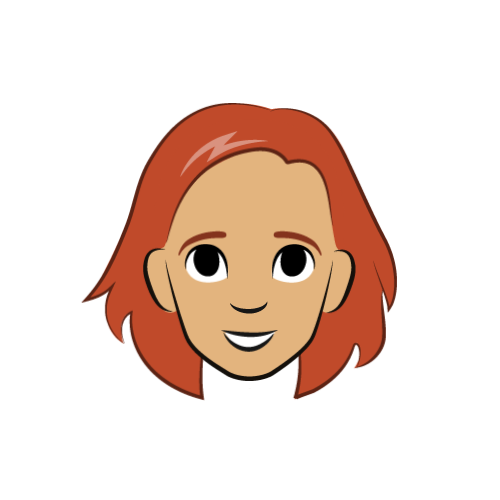

In [ ]:
image.load_img("/content/cartoonset10k/cs10638147595620592696.png")

In [ ]:
import pandas as pd
print(pd.read_csv('/content/cartoonset10k/cs10638147595620592696.csv'))

               eye_angle   0    3
0             eye_lashes   1    2
1                eye_lid   1    2
2            chin_length   0    3
3         eyebrow_weight   1    2
4          eyebrow_shape  12   14
5      eyebrow_thickness   1    4
6             face_shape   2    7
7            facial_hair  14   15
8                   hair  82  111
9              eye_color   4    5
10            face_color   5   11
11            hair_color   3   10
12               glasses  11   12
13         glasses_color   3    7
14             eye_slant   0    3
15         eyebrow_width   1    3
16  eye_eyebrow_distance   2    3


In [ ]:
all_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
all_flenames = []

#    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
 #                                      target_size=(IMG_WIDTH, IMG_HEIGHT)))       


# цикл для итерации по каждому имени текста в общей папке
for file_name in os.listdir("/content/cartoonset10k/"):

    # Выделение имени класса и типа выборки из имени файла
    m = re.match('(.+)(\.png)', file_name)# (\S+)_
    # Если выделение получилось, то файл обрабатывается
    if m:
      #print(m[1])
      all_flenames.append(m[1]+m[2])
      #all_images.append(np.array(image.load_img("/content/"+file_name,target_size=(250, 250))))#,target_size=(IMG_WIDTH, IMG_HEIGHT)

len(all_flenames)
#all_images=np.array(all_images)

10000

In [ ]:
import tensorflow as tf

class TImage_Datagen(tf.keras.utils.Sequence):

    def __init__(self, Filenames,Shape,Dir, batch_size):
        print("__init__")
        self.Filenames = Filenames
        self.batch_size = batch_size
        self.Shape = Shape
        self.Dir = Dir
    def __len__(self):
        #print("__len__",int(len(self.x1_start) / self.batch_size))
        return int(len(self.Filenames) / self.batch_size)#math.ceil

    def __getitem__(self, idx):
        #print("__getitem__",idx)
        batch_x = list()
        #batch_y = list()
        #print(idx,self.batch_size)
        for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
          batch_x.append(np.array(image.load_img(self.Dir+self.Filenames[i],target_size=self.Shape))/255)
        batch_x=np.array(batch_x)
        batch_y=batch_x.copy()
        
        return batch_x,batch_y

In [ ]:
datagen=TImage_Datagen(all_flenames,(106,106),"/content/cartoonset10k/",128)

__init__


In [ ]:
print(np.shape(datagen[0]))

(2, 128, 106, 106, 3)


In [ ]:
def showResult(re): # Получим 16 картинок
    
    total = 4                               # Считаем полное количесво выводимых мультяшек +1
    plt.figure(figsize=(20, 20))       # Создаем заготовку для финальной картинки 10x10
    num = 1                                  # Счетчик выводимых мультяшек
    for i in range(16):                     # Цикл по картинкам
        ax = plt.subplot(total, total, num)  # Добавим место для графика
        img = re[i]            # Сформируем очередную картинку
        num += 1                             # Инкремент номера графика        
        plt.imshow(img.squeeze())            # Рисуем пмультяшек
        ax.get_xaxis().set_visible(False)    # Спрячем ось X
        ax.get_yaxis().set_visible(False)    # Спрячем ось Y

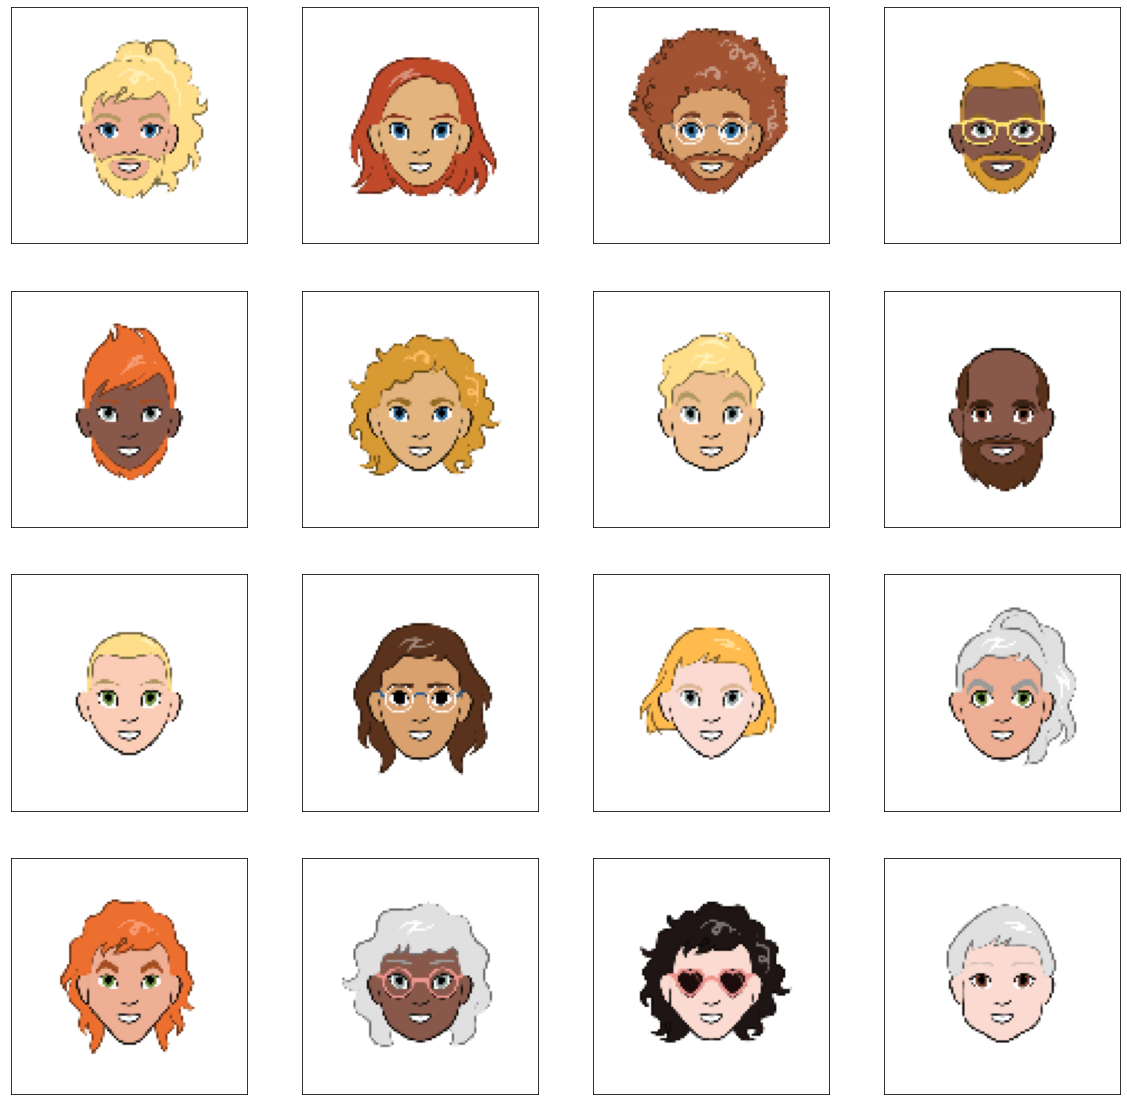

In [ ]:
# Взглянем на первые 16 изображений обучающей выборки

showResult(np.array(datagen[0][0])[:16])

In [ ]:
# Создадим сверточный энкодер
input_img = Input(shape=datagen[0][0][0].shape)                     # Добавим входной слой
print(input_img.shape)
x = Conv2D(16,3, strides=1,padding='valid',activation='relu')(input_img)
print(x.shape)
#x = Conv2D(16,3, strides=1,padding='valid',activation='relu')(x)
#print(x.shape)
x = MaxPooling2D()(x)
print(x.shape)
x = Conv2D(32,3, strides=1,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
print(x.shape)
x = Conv2D(32,3, strides=1,padding='valid',activation='relu')(x)
print(x.shape)
x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
x = MaxPooling2D()(x)
print(x.shape)
#x = Conv2D(64,3, strides=1,padding='valid',activation='relu')(x)
#print(x.shape)
#x = Conv2D(64,3, strides=1,padding='valid',activation='relu')(x)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
#print(x.shape)
#x = MaxPooling2D()(x)
#print(x.shape)
#x = Conv2D(128,3, strides=1,padding='valid',activation='relu')(x)
#print(x.shape)
#x = Conv2D(128,3, strides=1,padding='valid',activation='relu')(x)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
#print(x.shape)
#x = MaxPooling2D()(x)
#print(x.shape)
#x = Conv2D(256,3, strides=1,padding='valid',activation='relu')(x)
#print(x.shape)
#x = MaxPooling2D()(x)
#print(x.shape)
#x = Conv2D(8,3, strides=1,padding='same',activation='relu')(x)
#print(x.shape)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
pre_flatten_shape=x.shape[1:]
print(pre_flatten_shape)
x =Flatten()(x)                                    # Добавим Flatten
print(x.shape)
x =Dense(1500,activation='relu')(x)                                    # Добавим Flatten
print(x.shape)
Enc_shape=x.shape[1]
hidden_dim=Enc_shape
print(hidden_dim)
#x = Dense(2, activation='linear')(flatten)               # Добавим выходной dense слой

(None, 106, 106, 3)
(None, 104, 104, 16)
(None, 52, 52, 16)
(None, 50, 50, 32)
(None, 48, 48, 32)
(None, 24, 24, 32)
(24, 24, 32)
(None, 18432)
(None, 1500)
1500


In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                           # На выходе - тензор случайных чисел 

In [ ]:
 # Соберем энкодер

encoderVAEС = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=Enc_shape)                            # Добавим входной слой
print(input_enc.shape)
d =Dense(Enc_shape,activation='relu')(input_enc)                                    # Добавим Flatten
print(d.shape)
d =Dense(pre_flatten_shape[0]*pre_flatten_shape[1]*pre_flatten_shape[2],activation='relu')(d)                                    # Добавим Flatten
print(d.shape)
d = Reshape(pre_flatten_shape)(d)                               # Решейпим 1D тензор в 3D тензор
#print(d.shape)
#d = Conv2DTranspose(256, kernel_size=3, strides= 1,padding='same',activation='relu')(d)
#print(d.shape)
#d = Conv2DTranspose(256, kernel_size=3, strides= 2,padding='same',activation='relu')(d)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
#print(d.shape)
#d = Conv2DTranspose(128, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
#print(d.shape)
#d = Conv2DTranspose(128, kernel_size=3, strides= 2,padding='same',activation='relu')(d)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
#print(d.shape)
#d = Conv2DTranspose(128, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
#print(d.shape)
#d = Conv2DTranspose(64, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
#print(d.shape)
#d = Conv2DTranspose(64, kernel_size=3, strides= 2,padding='same',activation='relu')(d)
#print(d.shape)
#d = Conv2DTranspose(64, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
#print(d.shape)
#d = Conv2DTranspose(32, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
#x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
print(d.shape)
d = Conv2DTranspose(32, kernel_size=3, strides= 2,padding='same',activation='relu')(d)
print(d.shape)
d = Conv2DTranspose(32, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
print(d.shape)
d = Conv2DTranspose(16, kernel_size=3, strides= 1,padding='valid',activation='relu')(d)
d = BatchNormalization()(d)                                                          # Добавим нормализацию по батчу
print(d.shape)
d = Conv2DTranspose(16, kernel_size=3, strides= 2,padding='same',activation='relu')(d)
print(d.shape)
d = Conv2DTranspose(16, kernel_size=3, strides= 1,padding='valid',activation='sigmoid')(d)
print(d.shape)
decoded = Conv2DTranspose(3, kernel_size=3, strides= 1,padding='same',activation='sigmoid')(d)
print(decoded.shape)

(None, 1500)
(None, 1500)
(None, 18432)
(None, 24, 24, 32)
(None, 48, 48, 32)
(None, 50, 50, 32)
(None, 52, 52, 16)
(None, 104, 104, 16)
(None, 106, 106, 16)
(None, 106, 106, 3)


In [ ]:
# Соберем декодер

decoderVAEС = keras.Model(input_enc, decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAEС(encoderVAEС(input_img)[2]) 

In [ ]:
# Соберем наши сетки

vaec = keras.Model(input_img, decoderVAEС(encoderVAEС(input_img)[2])) # Соберем VAE

In [ ]:
vaec.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 106, 106, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 1500),            32167092  
                              (None, 1500),                      
                              (None, 1500)]                      
                                                                 
 decoder (Functional)        (None, 106, 106, 3)       29946191  
                                                                 
Total params: 62,113,283
Trainable params: 62,113,123
Non-trainable params: 160
_________________________________________________________________


In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)/20      # Суммируем лоссы - здесь можно вводить веса  
vaec.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Выведем состав энкодера
encoderVAEС.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 106, 106, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 104, 104, 16  448         ['input_45[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_59 (MaxPooling2D  (None, 52, 52, 16)  0           ['conv2d_104[0][0]']             
 )                                                                                          

In [ ]:
#  Выведем состав энкодера
decoderVAEС.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 1500)]            0         
                                                                 
 dense_94 (Dense)            (None, 1500)              2251500   
                                                                 
 dense_95 (Dense)            (None, 18432)             27666432  
                                                                 
 reshape_19 (Reshape)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_transpose_129 (Conv2  (None, 48, 48, 32)       9248      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_130 (Conv2  (None, 50, 50, 32)       9248      
 DTranspose)                                               

In [ ]:
# Компилируем VAE

vaec.compile(optimizer=tf.keras.optimizers.Adam(0.0001)) # оптимайзер ADAM

In [ ]:
vaec.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 106, 106, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 1500),       32167092    ['input_45[0][0]',               
                                 (None, 1500),                    'input_45[0][0]']               
                                 (None, 1500)]                                                    
                                                                                                  
 decoder (Functional)           (None, 106, 106, 3)  29946191    ['encoder[0][2]',         

In [ ]:
# Запускаем обучениe

vaec.fit(datagen,      # Обучающая выборка
        epochs=10,      # 10 эпох
        batch_size=128, # размер батча
        shuffle=True)  # обучающую выборку перемешиваем

Epoch 1/10
78/78 [==============================] - 66s 812ms/step - loss: 300.9431
Epoch 2/10
78/78 [==============================] - 64s 816ms/step - loss: 18.7451
Epoch 3/10
78/78 [==============================] - 64s 823ms/step - loss: 15.4856
Epoch 4/10
78/78 [==============================] - 63s 808ms/step - loss: 13.7509
Epoch 5/10
78/78 [==============================] - 63s 799ms/step - loss: 12.5711
Epoch 6/10
78/78 [==============================] - 63s 802ms/step - loss: 11.7531
Epoch 7/10
78/78 [==============================] - 63s 799ms/step - loss: 11.1522
Epoch 8/10
78/78 [==============================] - 63s 806ms/step - loss: 10.5951
Epoch 9/10
78/78 [==============================] - 63s 808ms/step - loss: 10.1528
Epoch 10/10
78/78 [==============================] - 63s 804ms/step - loss: 9.8717


In [ ]:
vaec.fit(datagen,epochs=10,batch_size=128,shuffle=True)

Epoch 1/10
78/78 [==============================] - 65s 836ms/step - loss: 7.1118
Epoch 2/10
78/78 [==============================] - 65s 833ms/step - loss: 7.0766
Epoch 3/10
78/78 [==============================] - 65s 825ms/step - loss: 7.0662
Epoch 4/10
78/78 [==============================] - 65s 829ms/step - loss: 7.0161
Epoch 5/10
78/78 [==============================] - 65s 827ms/step - loss: 7.0645
Epoch 6/10
78/78 [==============================] - 64s 823ms/step - loss: 6.9934
Epoch 7/10
78/78 [==============================] - 65s 829ms/step - loss: 7.0265
Epoch 8/10
78/78 [==============================] - 65s 824ms/step - loss: 6.9631
Epoch 9/10
78/78 [==============================] - 65s 827ms/step - loss: 6.9722
Epoch 10/10
78/78 [==============================] - 64s 823ms/step - loss: 6.9860


In [ ]:
# Определим функцию отображения массива
def showArray(ArrayX): # Получим обученный декодер
    n = 5                                                              
    plt.figure(figsize=(20, 20))                                # Создаем заготовку для финальной картинки 
    cnt=0
    for i in range(0, n):                                          # Цикл по горизонтали пространства Z
     for j in range(0,n):                                         # Цикл по вертикали пространства Z
        ax = plt.subplot(n, n, cnt+1)                           # Добавим место для графика
        img = ArrayX[cnt]
        cnt += 1                                                      # Инкремент номера графика
        plt.imshow(img.squeeze())
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

In [ ]:
#Исходные

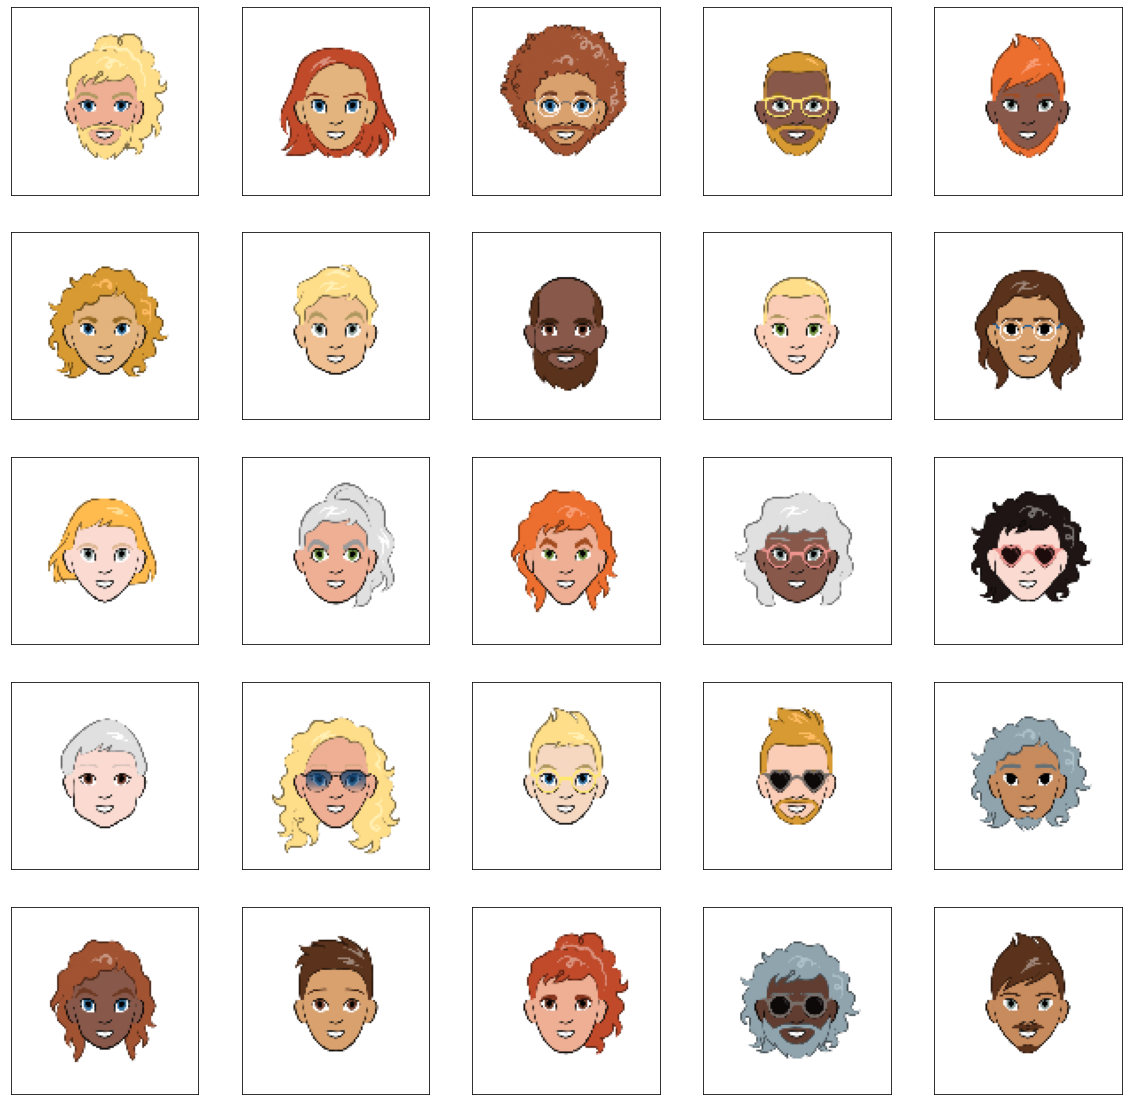

In [ ]:
showArray(datagen[0][0])

Восстановленные

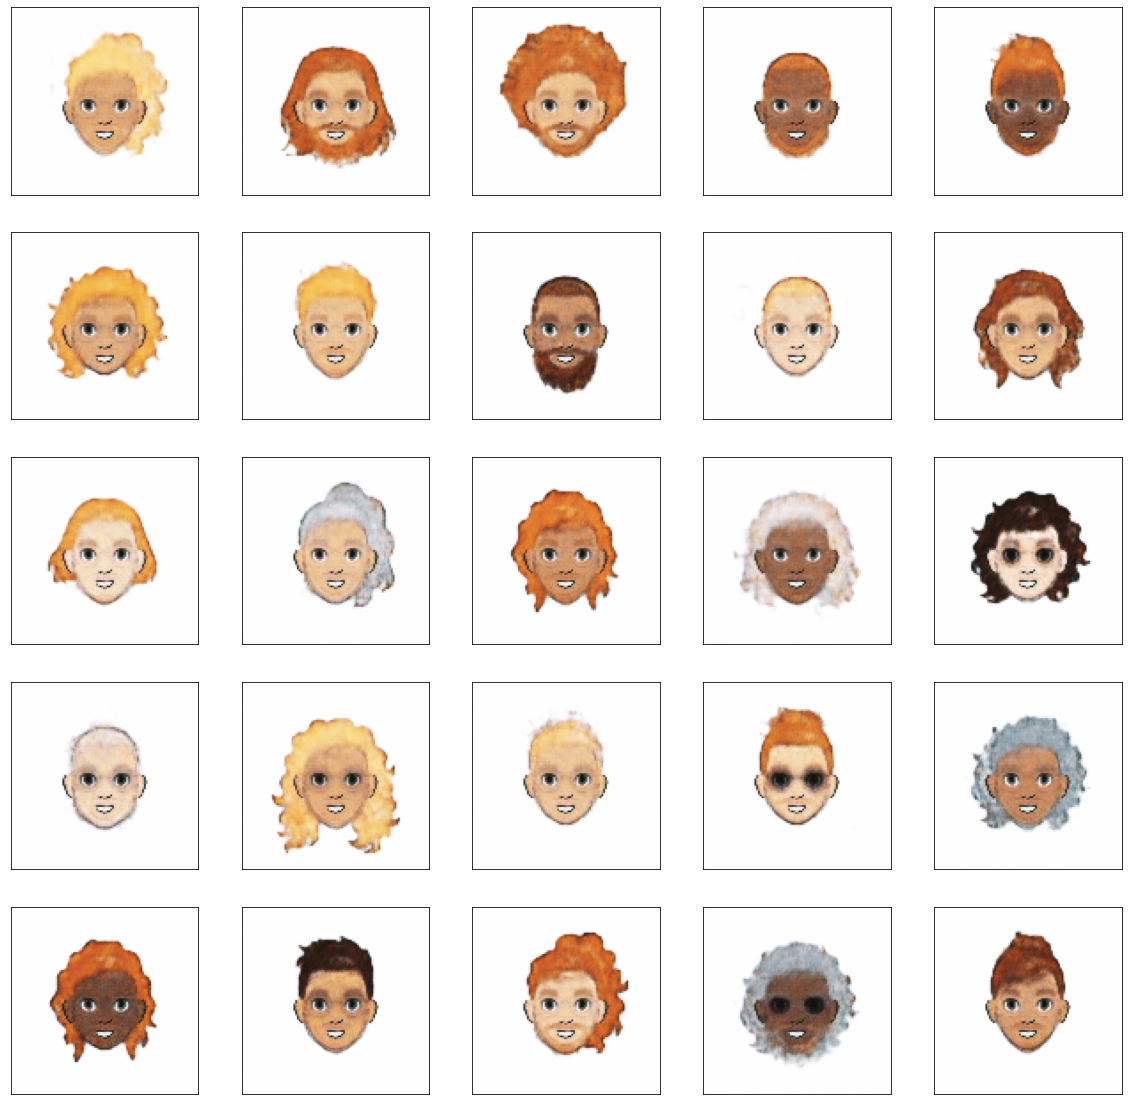

In [ ]:
 showArray(np.array(vaec.predict(datagen[0][0])))

In [ ]:
TestPredict=encoderVAEС.predict(datagen[0][0])[2]
MeanDim=np.array(TestPredict.mean(axis=0))
StdDim=np.array(TestPredict.std(axis=0))

NormalVector1 = K.random_normal(shape=(128, 1500), mean=0., stddev=1)

NewPoints=NormalVector1*StdDim*2+MeanDim

In [ ]:
Generated=decoderVAEС.predict(NewPoints)

Сгенерированные

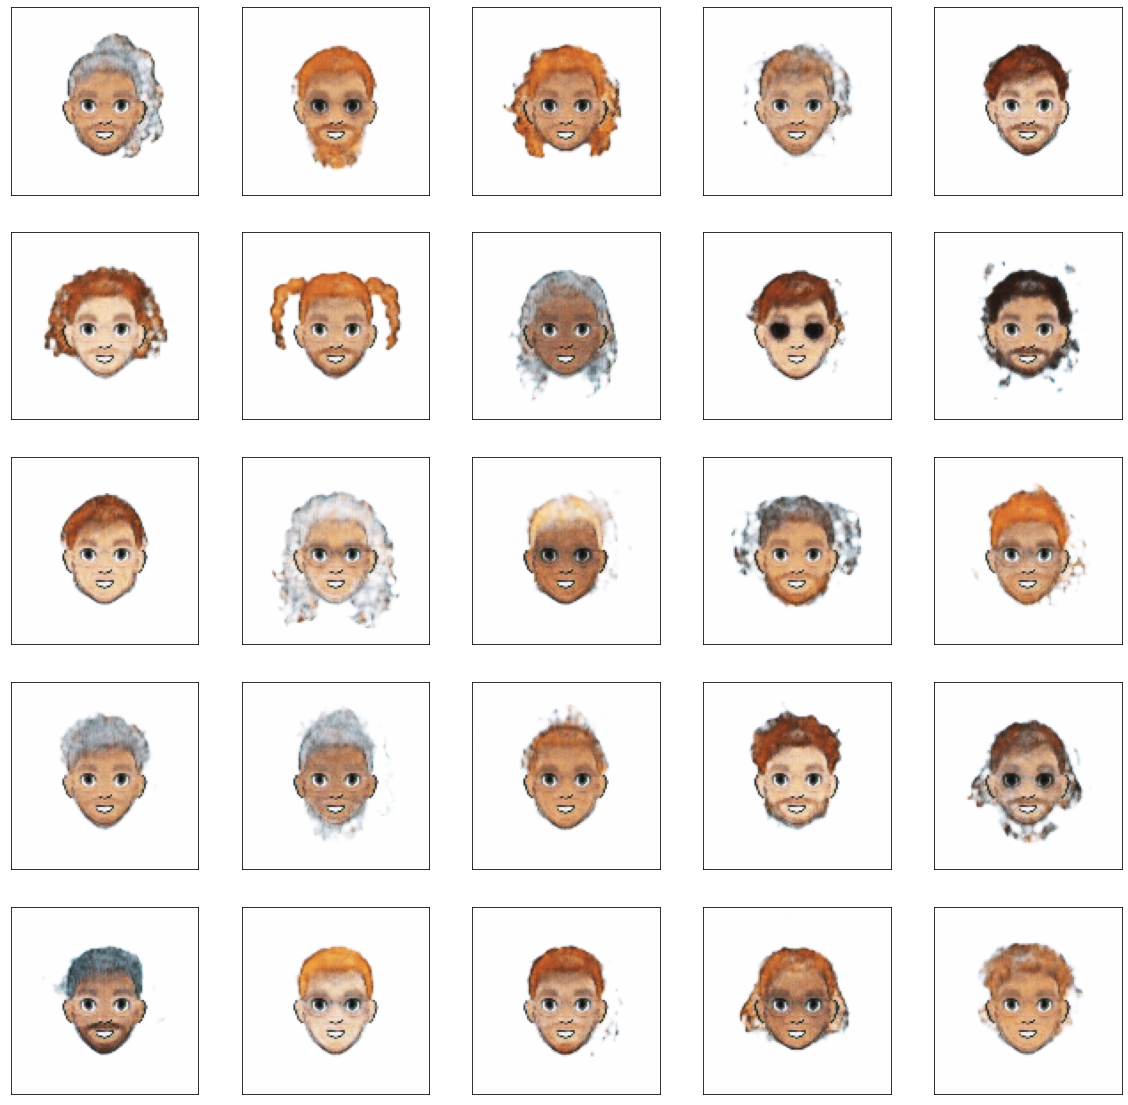

In [ ]:
 showArray(Generated)